#Black Jack Reinforcement Learning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns; sns.set()

from copy import deepcopy
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D 

## Black Jack Environment Implementation

In [3]:
class BlackJack():
    def __init__(self):
          """
          Init the first state by picking a 2 random cards for the dealer and 
          player each 
          """
          self.deck = self.generate_deck()
          player_hand, self.deck = self.draw_card([], self.deck)
          dealer_hand, self.deck = self.draw_card([], self.deck)
          player_hand, self.deck = self.draw_card(player_hand, self.deck)

          player_score = self.score_hand(player_hand)
          # The dealer reveals one card, so they have a known score and a true 
          # score
          dealer_known_score = self.score_hand(dealer_hand)
          dealer_hand, self.deck = self.draw_card(dealer_hand, self.deck)
          dealer_true_score = self.score_hand(dealer_hand)

          self.state = {"dealer_hand": dealer_hand, "player_hand": player_hand, 
                        "dealer_known_score": dealer_known_score, 
                        "dealer_true_score": dealer_true_score,  
                        "player_score": player_score} # initial state
          self.actions = ("hit", "stand")
                
          init_state = self.state.copy() # game history, recording (state, reward) and action of each step
          self.history = [init_state]
    
    def step(self, state, action):
        """
        One turn for the player, ending when the player busts, stands, or wins
        with black jack

        Returns
        -------
        state : state, the terminal state of the game sequence
        reward : int, the reward obtained in the terminal state of the game sequence
        """
        self.history.append({"player": action})

        if action == "hit":
            self.state['player_hand'], self.deck = self.draw_card(self.state['player_hand'], self.deck)
            self.state['player_score'] = self.score_hand(self.state['player_hand'])

            new_state = self.state.copy()

            if self.goes_bust(self.state['player_score']):
                # player goes bust
                reward = -1
                state = "terminal"
                self.history.append(state)
                return state, reward
            
            else:
                # player does not bust and can either hit or stand
                reward = 0
                self.history.append(new_state)
                return self.state, reward

         
        elif self.state['player_score'] == 21 and not self.state['dealer_true_score'] == 21:
            # player wins with a black jack (1.5 reward)
            reward = 1.5
            state = "terminal"
            self.history.append(state)
            return state, reward

        else:
            # player stands, outcome of game unknown until dealer's turn
            new_state = self.state.copy()
            self.history.append(new_state)
            
            state, reward = self.dealer_moves()
            return state, reward

    def dealer_moves(self):
        """
        Fixed dealer policy
        
        Returns
        -------
        state : state, the terminal state of the game sequence
        reward : int, the reward obtained in the terminal state of the game sequence
        """
        # dealer hits as long as his score is < 17
        while self.state['dealer_true_score'] < 17:
            self.state['dealer_hand'], self.deck = self.draw_card(self.state['dealer_hand'], self.deck)
            self.state['dealer_true_score'] = self.score_hand(self.state['dealer_hand'])

            
            new_state = self.state.copy()
            self.history.append({"dealer": "hit"})
            self.history.append(new_state)
            
            
            if self.goes_bust(self.state['dealer_true_score']):
                # dealer goes bust, player wins
                reward = 1
                state = "terminal"
                self.history.append(state)
                return state, reward

        # dealer stands when score >= 17
        self.history.append({"dealer": "stand"})  
        
        player_score = self.state['player_score']
        dealer_score = self.state['dealer_true_score']  
        
        state = "terminal"
        self.history.append(state)
        # Compare player and dealer scores
        if dealer_score < player_score: # player wins
            reward = 1
            return state, reward                    
        if dealer_score == player_score: # draw
            reward = 0
            return state, reward                 
        if dealer_score > player_score: # player loses
            reward = -1
            return state, reward


    def generate_deck(self, num_decks=6):
        """
        Generate a set of cards out of a number of standard 52-card decks. The
        default number is 6 decks.

        Returns
        -------
        deck : list, the deck the game is played with
        """
        deck = []

        for decks in range(num_decks):
            for suits in range(4):
                for values in range(13):
                    # add the deck values to the list. 1 is Ace
                    if values > 9:
                        deck.append(10)
                    else:
                        deck.append(values +1)
        
        # shuffle the deck
        random.shuffle(deck)
        return deck

    def score_hand(self, hand):
        """
        Calculate the score of a hand of cards 

        Returns
        -------
        hand_sum : int, the score
        """
        hand_sum = sum(hand)

        # If the hand has an ace, count its value as 11, unless that would cause
        # the hand to bust
        if hand.count(1) and hand_sum <= 11:
            hand_sum += 10

        return hand_sum

    def draw_card(self, hand, deck):
        """
        Draw a card from the deck and add it to the relevant hand of cards

        Returns
        -------
        deck : list, the deck of the game, with one card removed
        hand: list, the inputted hand, with one card added
        """
        # remove a card from the top of the deck and add it to the hand
        hand.append(deck.pop())
        
        # if there are less than 25 cards in the deck, reset the deck to allow
        # for continous playing
        if len(deck) < 25:
          deck = self.generate_deck

        return hand, deck

    def goes_bust(self, score):
        """
        Tells if the player/dealer goes bust
        
        Parameters
        ----------
        score : int, the current score
        
        Returns
        -------
        bool : either goes bust or not
        """
        return (score > 21)


In [4]:
# Example of an inital game state

BlackJack_game = BlackJack()
state_0 = BlackJack_game.state
print(state_0)

{'dealer_hand': [3, 8], 'player_hand': [9, 2], 'dealer_known_score': 3, 'dealer_true_score': 11, 'player_score': 11}


##Monte Carlo Control to Generate a Q-Value Function

The Monte Carlo Control approach generates a Q-value function by running rounds (`n_episodes`) of the game, and rewarding actions that result in wins from particular game states.

In [8]:
class MC_Control():
    
    def __init__(self, N_0, n_episodes):
        self.actions = ("hit", "stand") 
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior when starting to learn)
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        
        self.Q = self.init_to_zeros()   # init Q function to zeros
        self.N = self.init_to_zeros()   # init N to zeros
        self.policy = "random"          # arbitrarily init the MC learning with a random policy
 

    def learn_q_value_function(self):
        """
        Update the Q function until optimal value function is reached.
        
        Returns
        ----------
        Q : {state: (action)}, Q value for every state-action pair
        """
        for i in range(self.n_episodes):
            episode = self.play_episode() # run an episode using current policy
            self.policy = "e_greedy"      # policy switch from random to epsilon greedy
            for step in episode: 
                state, action, reward = step
                self.increment_counter(state, action) # increment state-action counter 
                self.update_Q(state, action, reward)  # update the Q value
                
        return self.Q 
                
    def init_to_zeros(self):
        """
        Init the Q function and the incremental counter N at 0 for every state-action pairs.
        
        Returns
        ----------
        lookup_table : {state: (action)}, a dictionnary of states as keys and actions as value
        """
        dealer_scores = np.arange(2, 12)
        player_scores = np.arange(4, 22)
        states = [(dealer_known_score, player_score) for player_score in player_scores for dealer_known_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stand": 0}  
            
        return lookup_table
        
    
    def play_episode(self):
        """
        Run a complete (from the initial state to the terminal state) Black Jack game sequence given a policy. 
        
        Returns
        ----------
        episode : [(state, action, reward)], a list of (statec, action, reward)
        """
        blackJack_game = BlackJack()           # init a game sequence
        state = blackJack_game.state.copy() # init state
        episode = []                     # list of the steps of the game sequence
        while state != "terminal":      
            # pick an action regarding the current state and policy
            if self.policy == "random":
                action = self.random_policy()
            if self.policy == "e_greedy":
                action = self.e_greedy_policy(state)
            next_state, reward = deepcopy(blackJack_game.step(state, action))
            step = (state, action, reward)
            state = next_state
            episode.append(step)   
            
        return episode
 
    def update_Q(self, state, action, reward):
        """
        Update Q value towards the error term. 
        
        Parameters
        ----------
        state : state, the current score
        action : string, the current score
        reward : int, the current score
        """
        lookup_state = (state["dealer_known_score"], state["player_score"])
        
        # The learning rate, decaying regarding the number of times an action-state pair 
        # has been explored. It scales the amount of modification we want to bring to 
        # the Q value function.
        alpha_t = 1 / self.get_state_action_counter(state, action)
        
        # We adjust the Q value towards the reality (observed) minus what we estimated.
        # This term is usually descrived as the error term.
        self.Q[lookup_state][action] += alpha_t * (reward - self.Q[lookup_state][action]) 
        
        return None

    def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.
        
        Parameters
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = (state["dealer_known_score"], state["player_score"])
        self.N[lookup_state][action] += 1        
        return None
    
    def random_policy(self):
        """
        Return an action follwing a random policy (state free).
        
        Returns
        ----------
        action : string, random action
        """
        action = random.choice(self.actions)
        
        return action
     
     
    def e_greedy_policy(self, state):
        """
        Return an action given an epsilon greedy policy (state based).  
        
        Parameters
        ----------
        state : state, state where we pick the action
        
        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        e = self.N_0/(self.N_0 + self.get_state_counter(state))
        if e > random.uniform(0, 1): 
            action = random.choice(self.actions)
        else:  
            action = self.get_action_w_max_value(state)
            
        return action
    
    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q value at a given state.
        
        Parameters
        ----------
        state : state, state 
        
        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        lookup_state = (state["dealer_known_score"], state["player_score"])
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get) 
            return action
    
    def get_state_counter(self, state):
        """
        Return the counter for a given state.
        
        Parameters
        ----------
        state : state, state 
        
        Returns
        ----------
        counter : int, the number of times a state as been explored
        """
        lookup_state = (state["dealer_known_score"], state["player_score"])
        counter = np.sum(list(self.N[lookup_state].values()))  
        
        return counter
    
    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.
        
        Parameters
        ----------
        state : state 
        action : string
        
        Returns
        ----------
        counter : int, the number of times an action-state pair as been explored
        """
        lookup_state = (state["dealer_known_score"], state["player_score"])
        counter = self.N[lookup_state][action]
        
        return counter
        

In [9]:
def plot_Q(n_episodes):
    """
    Graph a surface plot of the Q-value function
    """
    mc = MC_Control(N_0=100, n_episodes=n_episodes)
    mc.learn_q_value_function()
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')

    # Make data.
    dealer_showing = np.arange(1, 12)
    player_score = np.arange(1, 22)
    dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)

    max_Q = np.ndarray(shape=(21, 11))
    for state in mc.Q:
        max_Q[state[1]-1][state[0]-1] = max(mc.Q[state].values())


    # Plot the surface.
    surf = ax.plot_surface(dealer_showing, player_score, max_Q, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize plot
    ax.set_zlim(-1.51, 1.51)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    plt.xlabel('Dealer showing', fontsize=12)
    plt.ylabel('Player score', fontsize=12)
    plt.title('Optimal Q value function', fontsize=16)

    plt.xticks(np.arange(1, 12))
    plt.yticks(np.arange(1, 22))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

##Surface Plots of the Q-Value Function with Varying Numbers of Episodes

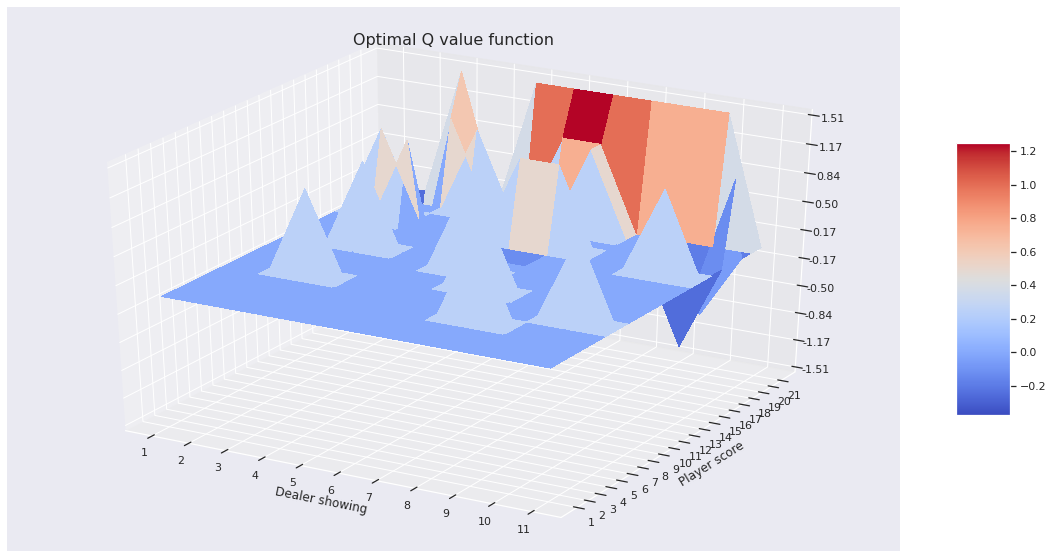

In [11]:
n = 100
plot_Q(n_episodes=n)

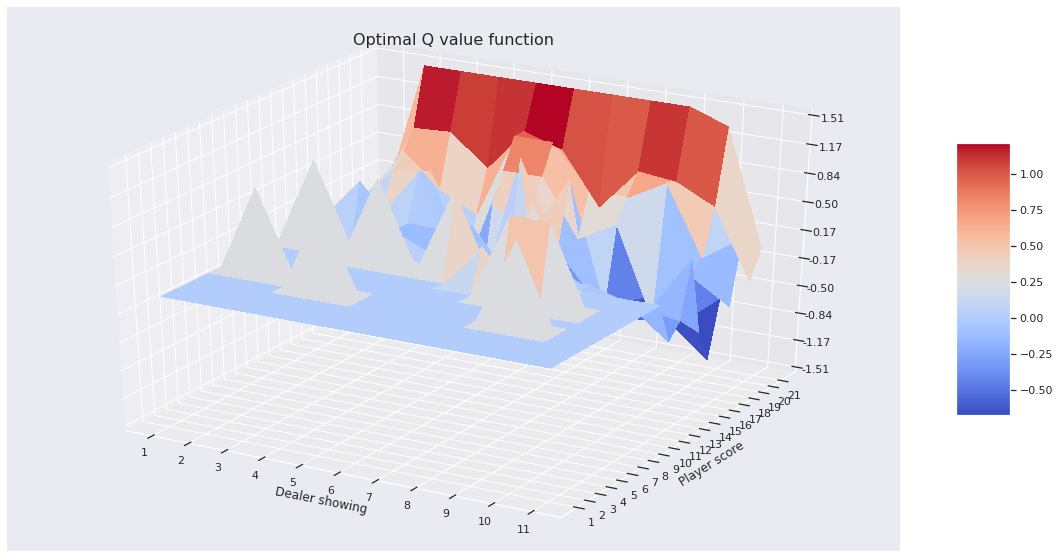

In [12]:
n = 1000
plot_Q(n_episodes=n)

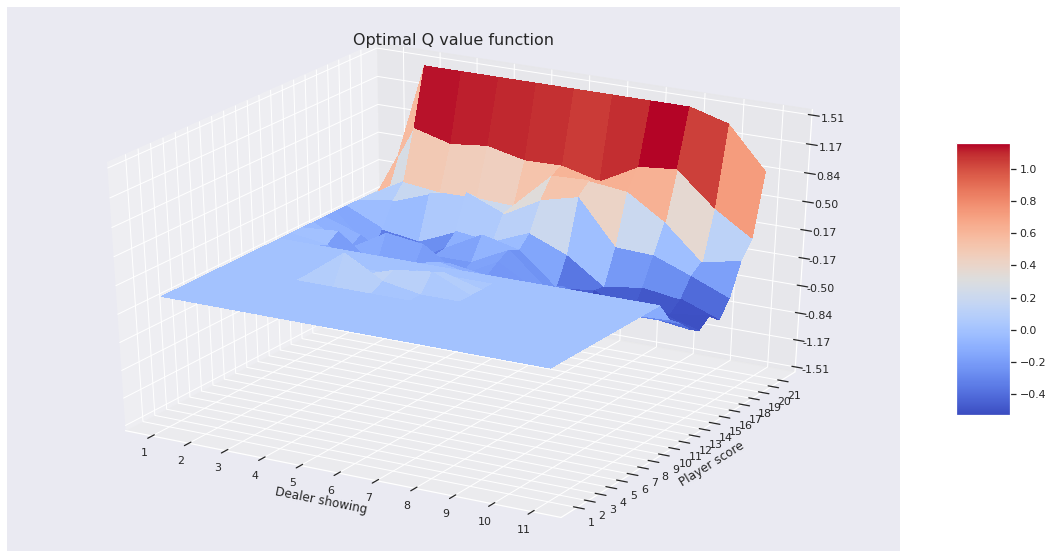

In [13]:
n = 10000
plot_Q(n_episodes=n)

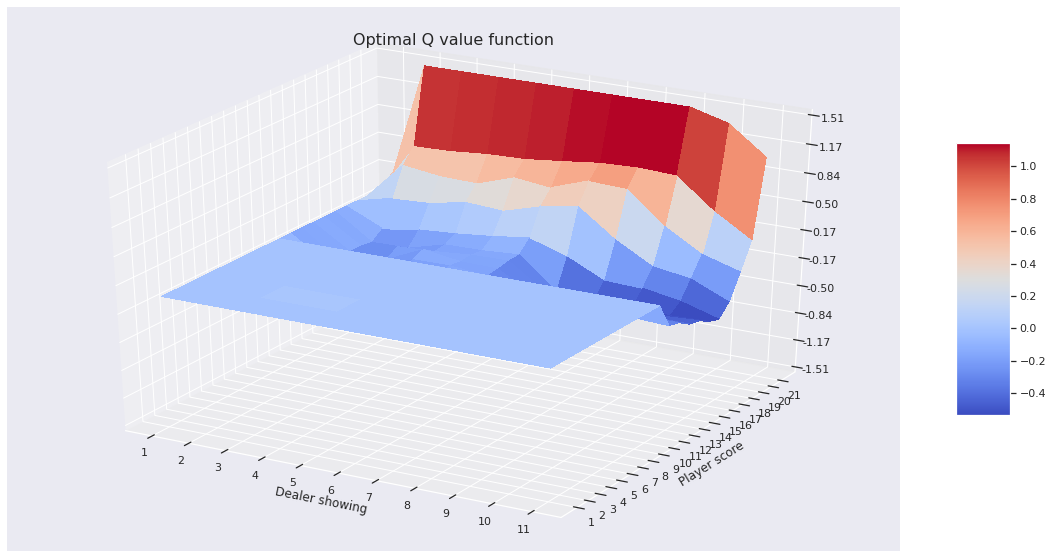

In [14]:
n = 100000
plot_Q(n_episodes=n)

##Pivot Table of Optimum moves

In [15]:
def plot_opt_policy(n_episodes):
    """
    Generate a pivot table of the optimal move for each game state based on the
    Q-value function from a specified number of episodes

    Parameters
    ----------
    n_episodes : int, number of episodes to generate the Q-value function
        
    Returns
    ----------
    df_pivot : dataframe, pivot table of the optimal moves

    """
    mc = MC_Control(N_0=100, n_episodes=n_episodes)
    mc.learn_q_value_function()
    df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
    states = list(mc.Q.keys())
    for i in range(len(states)):
        best_action = max(mc.Q[states[i]], key=mc.Q[states[i]].get)
        df.loc[i] = (states[i][0], states[i][1], best_action)

    df_pivot = df.pivot("player_score", "dealer_showing", "best_action")
    return df_pivot

In [19]:
n = 100000
df = plot_opt_policy(n_episodes=n)
df

dealer_showing,2,3,4,5,6,7,8,9,10,11
player_score,,,,,,,,,,
4,hit,hit,stand,hit,hit,hit,hit,hit,hit,hit
5,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
6,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
7,hit,hit,hit,stand,hit,hit,hit,hit,hit,hit
8,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
9,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
10,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
11,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
12,stand,hit,stand,stand,stand,hit,hit,hit,hit,hit


##Application
Here we use the moves from the pivot table to guide games of Black Jack to calculate the win-loss-tie ratio of a particular Q-value function.

In [21]:
def score_hand(hand):
  hand_sum = sum(hand)

  if hand.count(1) and hand_sum <= 11:
      hand_sum += 10

  return hand_sum

def get_move(player, dealer, df):
  player_score = score_hand(player)
  dealer_showing = dealer[0]
  if dealer_showing == 1:
    dealer_showing = 11
  return df[dealer_showing][player_score]

def generate_deck(num_decks=6):
  deck = []

  for decks in range(num_decks):
      for suits in range(4):
          for values in range(13):
              # add the deck values to the list. 1 is Ace
              if values > 9:
                  deck.append(10)
              else:
                  deck.append(values +1)

  random.shuffle(deck)
  return deck


def gameloop(deck):
        winners = []
        
        while deck:
            dealer = []
            player = []

            # Break out of loop if there are less than 30 cards in the deck.
            # This is to prevent any possibility of the deck running out of cards mid round
            if len(deck) < 30:
                break
            # Deals cards in alternating player order to simulate real gameplay
            player.append(deck.pop())
            dealer.append(deck.pop())
            player.append(deck.pop())
            dealer.append(deck.pop())

            # check if player or dealer has blackjack
            if score_hand(player) == 21 and not score_hand(dealer) == 21:
                winners.append(1.5)
                continue
            if score_hand(dealer) == 21 and not score_hand(player) == 21:
                winners.append(-1)
                continue
            if score_hand(player) == 21 and score_hand(dealer) == 21:
                winners.append(0)
                continue

            # player hit/stands
            while score_hand(player) <= 21:
                move = get_move(player, dealer, df)
                if move == "hit":
                    player.append(deck.pop())
                if move == "stand":
                    break
            
            # check if player bust
            if score_hand(player) > 21:
                winners.append(-1)
                continue

            # dealer must hit if hand is <= 16
            while score_hand(dealer) <= 16:
                dealer.append(deck.pop())

            # check if dealer bust
            if score_hand(dealer) > 21:
                winners.append(1)
                continue

            if score_hand(player) < score_hand(dealer):
                winners.append(-1)
            elif score_hand(dealer) < score_hand(player):
                winners.append(1)
            else:
                winners.append(0)

        return winners

In [22]:
running_overall_advantage = []
hist_dict = {1.5 : 0, 1 : 0, 0 : 0, -1 : 0, 'total' : 0}

for i in range(100000):
  deck = generate_deck()
  winners = gameloop(deck)

  for winner in winners:
    hist_dict[winner] += 1
    hist_dict['total'] += 1

  running_overall_advantage.append(sum(winners))

print(sum(running_overall_advantage)/len(running_overall_advantage))
print(hist_dict)

print("Win percentage: %.3f%%" % (sum([hist_dict[1.5], hist_dict[1]]) / hist_dict["total"] * 100))
print("Loss percentage: %.3f%%" % (hist_dict[-1] / hist_dict["total"] * 100))
print("Tie percentage: %.3f%%" % (hist_dict[0] / hist_dict["total"] * 100))

-1.937145
{1.5: 240315, 1: 2039672, 0: 445647, -1: 2593859, 'total': 5319493}
Win percentage: 42.861%
Loss percentage: 48.761%
Tie percentage: 8.378%
